In [1]:
%run ../modules/qpca

<b>General implementation of a Quantum PCA for any size covariance matrices.</b>

In [2]:
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram
from scipy.stats import ortho_group

Generation of the covariance matrix and normalization

In [3]:
#number of features
N = 8

data = scipy.random.rand(10,N)*20
means = np.mean(data,axis=0)
u=np.ones(len(data))[None] 
u=u.reshape((len(data),1)) 
means=means.reshape((len(data[0]),1))
centered = data-np.dot(u,means.T)



covmat = np.dot(centered.transpose(),centered)
covmat = covmat/np.trace(covmat)

for r in covmat:
    #print("&".join([str(c.round(4)) for c in r])+"\\")
    pass

eigvals, eigvecs = np.linalg.eig(covmat)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

In [4]:
def select_eigenvalues(eigenvalues_occurrences, bits, n):
    max_val = 1
    relevant_eigvals = []

    for i in range(n):
        eigenvalues_occurrences = [j for j in eigenvalues_occurrences if j[0] <= max_val]
        if len(eigenvalues_occurrences)<=0:
            break
        most_relevant = eigenvalues_occurrences.pop(-1)[0]
        max_val -= most_relevant - (0.5**(bits+1))
        relevant_eigvals.append(most_relevant)
    return relevant_eigvals

In [5]:
for i in range(N):
    print(f"Eigvector associated to {np.round(eigvals[i].real,5)}: [{','.join([str(j.real) for j in np.round(eigvecs.T[i],4)])} ].")

Eigvector associated to 0.00488: [0.157,-0.228,-0.2927,0.2364,0.0671,-0.0838,-0.6389,0.6017 ].
Eigvector associated to 0.01573: [-0.385,-0.5256,0.0384,0.0352,0.3275,0.653,-0.1146,-0.1612 ].
Eigvector associated to 0.03159: [0.377,-0.2465,0.5763,-0.0481,0.2318,-0.2929,-0.4096,-0.3942 ].
Eigvector associated to 0.06404: [-0.4621,0.3584,0.1688,-0.6202,-0.0878,0.0209,-0.4787,0.0866 ].
Eigvector associated to 0.08874: [-0.3721,0.3281,-0.1954,0.3194,0.6757,-0.3519,-0.0491,-0.1757 ].
Eigvector associated to 0.19966: [-0.4327,0.0424,0.498,0.6089,-0.4175,-0.064,-0.0734,0.0918 ].
Eigvector associated to 0.2227: [-0.3522,-0.581,0.0328,-0.2818,0.0194,-0.5628,0.2953,0.2314 ].
Eigvector associated to 0.37267: [-0.1473,-0.1885,-0.5147,0.0609,-0.4422,-0.1889,-0.2944,-0.5969 ].


[(0.3125, 1), (0.484375, 1), (0.40625, 1), (0.265625, 1), (0.796875, 1), (0.46875, 1), (0.171875, 1), (0.15625, 1), (0.5, 1), (0.140625, 2), (0.125, 4), (0.34375, 4), (0.1875, 6), (0.109375, 6), (0.390625, 8), (0.359375, 12), (0.984375, 13), (0.046875, 14), (0.078125, 23), (0.0, 335), (0.375, 355), (0.0625, 360), (0.09375, 370), (0.21875, 397), (0.203125, 399), (0.03125, 425), (0.015625, 458)]
[0.015625, 0.03125, 0.203125, 0.21875, 0.09375, 0.0625, 0.375, 0.0]
Using estimate for 0.015625: [ 0.40126917  0.50421948 -0.          0.18411492 -0.30532006 -0.54461929
  0.22549381 -0.3319179 ], with weight: 0.015625
Using estimate for 0.03125: [ 0.29488391 -0.20851441  0.58976782 -0.09325048  0.20851441 -0.26375219
 -0.45683219 -0.43738352], with weight: 0.03125
Using estimate for 0.203125: [ 0.48336824 -0.         -0.46363053 -0.5959364   0.4323377   0.
  0.          0.09667365], with weight: 0.203125
Using estimate for 0.21875: [ 0.37416574  0.57445626 -0.1         0.28284271 -0.          0.

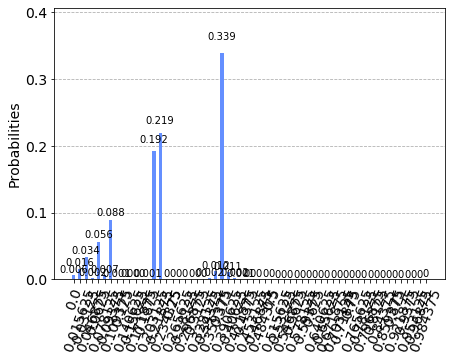

In [6]:
bits = 8
shots_per_vec1 = 100
shots_per_vec2 = 1000
roundoff = 2

pool = ortho_group.rvs(dim=N)
res = None
for i in range(N):
    initial = pool[i]
    if res is None:
        res = qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff)
    else:
        res.merge(qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff))
        
eigval_occurences = res.get_eigvals()
print(eigval_occurences)

#THRESHOLDING

relevant_eigvals = select_eigenvalues(eigval_occurences, bits-roundoff, N)
print(relevant_eigvals)

eigvec_weights = [i/sum(relevant_eigvals) for i in relevant_eigvals]

result = None
for ev,weight in zip(relevant_eigvals,eigvec_weights):
    initial = res.eigvec_from_eigval(ev)
    print(f"Using estimate for {ev}: {initial}, with weight: {weight}")
    if len(initial)==0:
        continue
    if result is None:
        result = qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff)
    else:
        result.merge(qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff))

plot_histogram(result.get_eigvals(False))

In [8]:
K = 4

#RETRIEVE EIGVECTORS ESTIMATES
estimated_eigenvalues = sorted(select_eigenvalues(result.get_eigvals(), bits-roundoff, N))
estimated_eigvals = [i for i in estimated_eigenvalues[-K:]]
print("eigenvalues considered ", estimated_eigvals)
eigenvectors = [result.eigvec_from_eigval(i) for i in estimated_eigenvalues]

eigval_diag = np.diag(estimated_eigvals)
estimated_eigvecs = np.array(eigenvectors[-K:]).T

lowrank_covmat_est = np.matmul(np.matmul(estimated_eigvecs,eigval_diag),estimated_eigvecs.T)
lowrank_covmat = np.matmul(np.matmul(eigvecs[:,-K:],np.diag(eigvals[-K:])),eigvecs[:,-K:].T)
diff = lowrank_covmat_est - lowrank_covmat
print("reconstruction error l2 norm ",np.linalg.norm(diff)/np.linalg.norm(lowrank_covmat))

#VECTORS ORTHOGONALITY
U = np.matmul(estimated_eigvecs.T, estimated_eigvecs)
print("vectors orthogonality error ",np.linalg.norm(U - np.eye(K))/K)

eigenvalues considered  [0.09375, 0.203125, 0.21875, 0.375]
reconstruction error l2 norm  0.61056150237095
vectors orthogonality error  0.16531410019220183


In [18]:
print("eigenvalues: ",estimated_eigvals)
err = 0
for i in range(K):
    v1 = result.eigvec_from_eigval(estimated_eigvals[-i-1])
    v2 = eigvecs[:,-i-1]
    d1 = np.linalg.norm(v1-v2)
    d2 = np.linalg.norm(v2+v1)
    err += d1 if d1 < d2 else d2
err /= K
print("average eigenvector error l2 norm: ",err)

eigenvalues:  [0.109375, 0.140625, 0.15625, 0.46875]
average eigenvector error l2 norm:  0.3538375884014342


In [ ]:
print(covmat)